In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
dir_sp_train = "/content/drive/My Drive/Parkinson Project Drawings/dataset/spiral/training"
dir_sp_test = "/content/drive/My Drive/Parkinson Project Drawings/dataset/spiral/testing"
dir_wv_train = "/content/drive/My Drive/Parkinson Project Drawings/dataset/wave/training"
dir_wv_test = "/content/drive/My Drive/Parkinson Project Drawings/dataset/wave/testing"

In [19]:
Name = []
for file in os.listdir(dir_sp_train):
    Name += [file]
print(Name)

['parkinson', 'healthy']


# **Data Preparation**

In [54]:
# Define image size and parameters
IMG_SIZE_SPIRAL = (256, 256)  # Spiral images
IMG_SIZE_WAVE = (512, 512)   # Wave images
BATCH_SIZE = 32
CLASSES = ['healthy', 'parkinson']

In [56]:
# Function to load and preprocess images
def load_and_preprocess_images(directory, img_size):
    images = []
    labels = []
    for label in CLASSES:
        path = os.path.join(directory, label)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            # Load image in grayscale
            img = load_img(img_path, color_mode='grayscale', target_size=img_size)
            img_array = img_to_array(img)
            # Normalize pixel values to [0, 1]
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

In [58]:
# Load spiral and wave datasets
X_spiral_train, y_spiral_train = load_and_preprocess_images(dir_sp_train, IMG_SIZE_SPIRAL)
X_spiral_test, y_spiral_test = load_and_preprocess_images(dir_sp_test, IMG_SIZE_SPIRAL)
X_wave_train, y_wave_train = load_and_preprocess_images(dir_wv_train, IMG_SIZE_WAVE)
X_wave_test, y_wave_test = load_and_preprocess_images(dir_wv_test, IMG_SIZE_WAVE)

In [59]:
# Encode labels (healthy=0, parkinson=1)
label_encoder = LabelEncoder()
y_spiral_train = to_categorical(label_encoder.fit_transform(y_spiral_train))
y_spiral_test = to_categorical(label_encoder.transform(y_spiral_test))
y_wave_train = to_categorical(label_encoder.fit_transform(y_wave_train))
y_wave_test = to_categorical(label_encoder.transform(y_wave_test))

In [60]:
# Data augmentation parameters (based on the paper)
spiral_datagen = ImageDataGenerator(
    rotation_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=[0.1, 1.5],
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.3, 1.0],
    shear_range=0.2
)

wave_datagen = ImageDataGenerator(
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.3, 1.8],
    shear_range=0.3
)

# **Build CNN Models**

In [61]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [62]:
# Function to build CNN model
def build_cnn_model(input_shape, name):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_initializer=glorot_uniform(), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ], name=name)
    return model

In [63]:
# Build spiral and wave CNN models
spiral_model = build_cnn_model(input_shape=(256, 256, 1), name='spiral_model')
wave_model = build_cnn_model(input_shape=(512, 512, 1), name='wave_model')

In [64]:
# Print model summary to identify layers
spiral_model.summary()

Model: "spiral_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,554 (56.61 MB)

 Trainable params: 14,839,106 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [65]:
# Compile models
spiral_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
wave_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [67]:
# Train spiral model
spiral_history = spiral_model.fit(
    spiral_datagen.flow(X_spiral_train, y_spiral_train, batch_size=BATCH_SIZE),
    validation_data=(X_spiral_test, y_spiral_test),
    epochs=400,
    callbacks=[early_stopping]
)

Epoch 1/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4875 - loss: 2.8918

KeyboardInterrupt: 

In [68]:
# Train wave model
wave_history = wave_model.fit(
    wave_datagen.flow(X_wave_train, y_wave_train, batch_size=BATCH_SIZE),
    validation_data=(X_wave_test, y_wave_test),
    epochs=400,
    callbacks=[early_stopping]
)

Epoch 1/400


KeyboardInterrupt: 

# **Generate Prediction Probabilities**

In [69]:
# Get prediction probabilities
spiral_probs = spiral_model.predict(X_spiral_test)
wave_probs = wave_model.predict(X_wave_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [70]:
# Combine probabilities as features for meta-classifier
meta_features = np.concatenate([spiral_probs, wave_probs], axis=1)  # Shape: (n_samples, 4)

# **Ensemble Meta-Classifier**

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [72]:
# Prepare true labels for meta-classifier
y_test = label_encoder.transform(label_encoder.inverse_transform(y_spiral_test.argmax(axis=1)))  # Convert one-hot back to integer labels using inverse transform

In [73]:
# Define meta-classifiers
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [74]:
# Create ensemble voting classifier
ensemble = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf)
], voting='soft')  # Soft voting for averaging probabilities

In [75]:
# Train ensemble model
ensemble.fit(meta_features, y_test)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [76]:
# Predict with ensemble
ensemble_preds = ensemble.predict(meta_features)
ensemble_probs = ensemble.predict_proba(meta_features)

In [77]:
# Evaluate ensemble model
print("Ensemble Classification Report:")
print(classification_report(y_test, ensemble_preds, target_names=CLASSES))

Ensemble Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        15
   parkinson       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [78]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, ensemble_preds)
precision = precision_score(y_test, ensemble_preds, average='weighted')
recall = recall_score(y_test, ensemble_preds, average='weighted')
f1 = f1_score(y_test, ensemble_preds, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000


# **Visualize Training History**

NameError: name 'spiral_history' is not defined

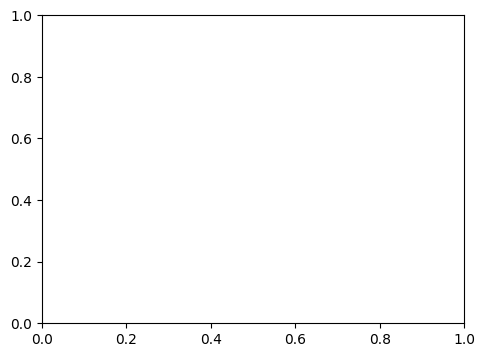

In [79]:
# Plot training history for spiral model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(spiral_history.history['accuracy'], label='Train Accuracy')
plt.plot(spiral_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Spiral Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(spiral_history.history['loss'], label='Train Loss')
plt.plot(spiral_history.history['val_loss'], label='Validation Loss')
plt.title('Spiral Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'wave_history' is not defined

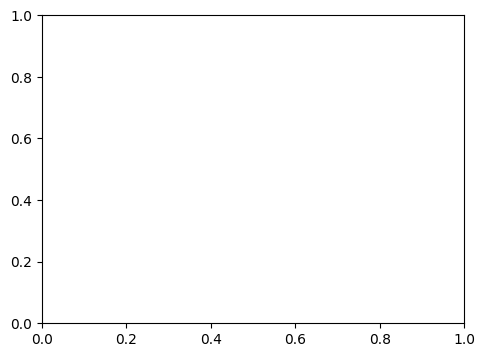

In [80]:
# Plot training history for wave model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(wave_history.history['accuracy'], label='Train Accuracy')
plt.plot(wave_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Wave Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wave_history.history['loss'], label='Train Loss')
plt.plot(wave_history.history['val_loss'], label='Validation Loss')
plt.title('Wave Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Save Models**

In [ ]:
# Save CNN models
spiral_model.save('/content/drive/My Drive/Parkinson Project Drawings/spiral_model.h5')
wave_model.save('/content/drive/My Drive/Parkinson Project Drawings/wave_model.h5')

In [ ]:
# Save ensemble model
import joblib
joblib.dump(ensemble, '/content/drive/My Drive/Parkinson Project Drawings/ensemble_model.pkl')

# **Inference on New Data**

In [81]:
def predict_new_image(spiral_path, wave_path):
    # Load and preprocess new images
    spiral_img = load_img(spiral_path, color_mode='grayscale', target_size=IMG_SIZE_SPIRAL)
    spiral_img = img_to_array(spiral_img) / 255.0
    spiral_img = np.expand_dims(spiral_img, axis=0)  # Add batch dimension

    wave_img = load_img(wave_path, color_mode='grayscale', target_size=IMG_SIZE_WAVE)
    wave_img = img_to_array(wave_img) / 255.0
    wave_img = np.expand_dims(wave_img, axis=0)  # Add batch dimension

    # Get probabilities from CNNs
    spiral_prob = spiral_model.predict(spiral_img)
    wave_prob = wave_model.predict(wave_img)

    # Combine probabilities
    meta_input = np.concatenate([spiral_prob, wave_prob], axis=1)

    # Predict with ensemble
    pred = ensemble.predict(meta_input)
    prob = ensemble.predict_proba(meta_input)

    return CLASSES[pred[0]], prob[0]

In [82]:
# Example usage
spiral_path = '/content/drive/My Drive/Parkinson Project Drawings/dataset/spiral/testing/healthy/V01HE01.png'
wave_path = '/content/drive/My Drive/Parkinson Project Drawings/dataset/wave/testing/parkinson/V01PO01.png'
label, probs = predict_new_image(spiral_path, wave_path)
print(f"Predicted: {label}, Probabilities: {probs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Predicted: parkinson, Probabilities: [0.34 0.66]
